In [1]:
import os
import warnings
import numpy as np
import scanpy as sc
import custom_tools
import anndata as ad
import seaborn as sns
import decoupler as dc
from pathlib import Path
from matplotlib import rcParams
import matplotlib.pyplot as plt
from dataset import TissueDataset
from pathlib import Path
import matplotlib


warnings.simplefilter(action='ignore')
sc.settings.verbosity = 0
# Set figure params
sc.set_figure_params(scanpy=True, facecolor="white", dpi=80, dpi_save=300)


<h1>Loading model and dataset</h1>

In [2]:
# Read json file
# exp_name = "GATV2_NegativeLogLikelihood_month_04-12-2023"
# job_id = "fombnNMthdocYhDPmAjaBQ"
exp_name = "JacksonFischer"
dataset_name = "JacksonFischer"
job_id = "2mYvWJwUarIJkw0vvUbl3Q"
PLT_PATH = f"../plots/analysis/{exp_name}_{job_id}"
Path(PLT_PATH).mkdir(parents=True, exist_ok=True)
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")



# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, device=device)
dataset = TissueDataset(os.path.join(f"../data/{dataset_name}", "month"),  "month")

# Read the explanations adata
adata_exp = sc.read_h5ad(f"../data/out_data/adatafiles/{dataset_name}/{exp_name}_{job_id}_concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

# for mod in model.modules():
#    print(mod)



Seed set to 42
Seed set to 42


GPU is available on this device!
Target prediction: OSmonth


In [3]:
import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)
emd_cnv, related_data_cnv = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, mode="CNV", batch_size=1)

In [4]:
embedding_arr = np.array(emd[0])
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, tumor_grade_lst, censor_lst= [], [], [], [], [], []
for data in related_data:
    pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    tumor_grade_lst.append(str(data.tumor_grade.item()))
    censor_lst.append(data.is_censored[0].item())
embedding_arr.shape

(1114, 128)

In [5]:
adata_emb = ad.AnnData(embedding_arr)
adata_emb.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata_emb.obs_names = img_id_list
adata_emb.obs["img_id"] = img_id_list
adata_emb.obs["img_id"] = adata_emb.obs["img_id"].astype("category")
adata_emb.obs["osmonth"] = osmonth_lst
adata_emb.obs["p_id"] = pid_list
adata_emb.obs["clinical_type"] = clinical_type_lst
adata_emb.obs["tumor_grade"] = tumor_grade_lst
adata_emb.obs["is_censored"] = censor_lst

In [6]:
sc.tl.pca(adata_emb, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_emb)
sc.tl.leiden(adata_emb, key_added = "leiden", resolution=0.1)
sc.tl.umap(adata_emb)
# sc.pl.umap(adata, color=["osmonth", "leiden"])
upper_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))

adata_emb.obs["high_surv"]="0"
adata_emb.obs["low_surv"]="0"

adata_emb.obs.loc[adata_emb.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb.obs.loc[adata_emb.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"



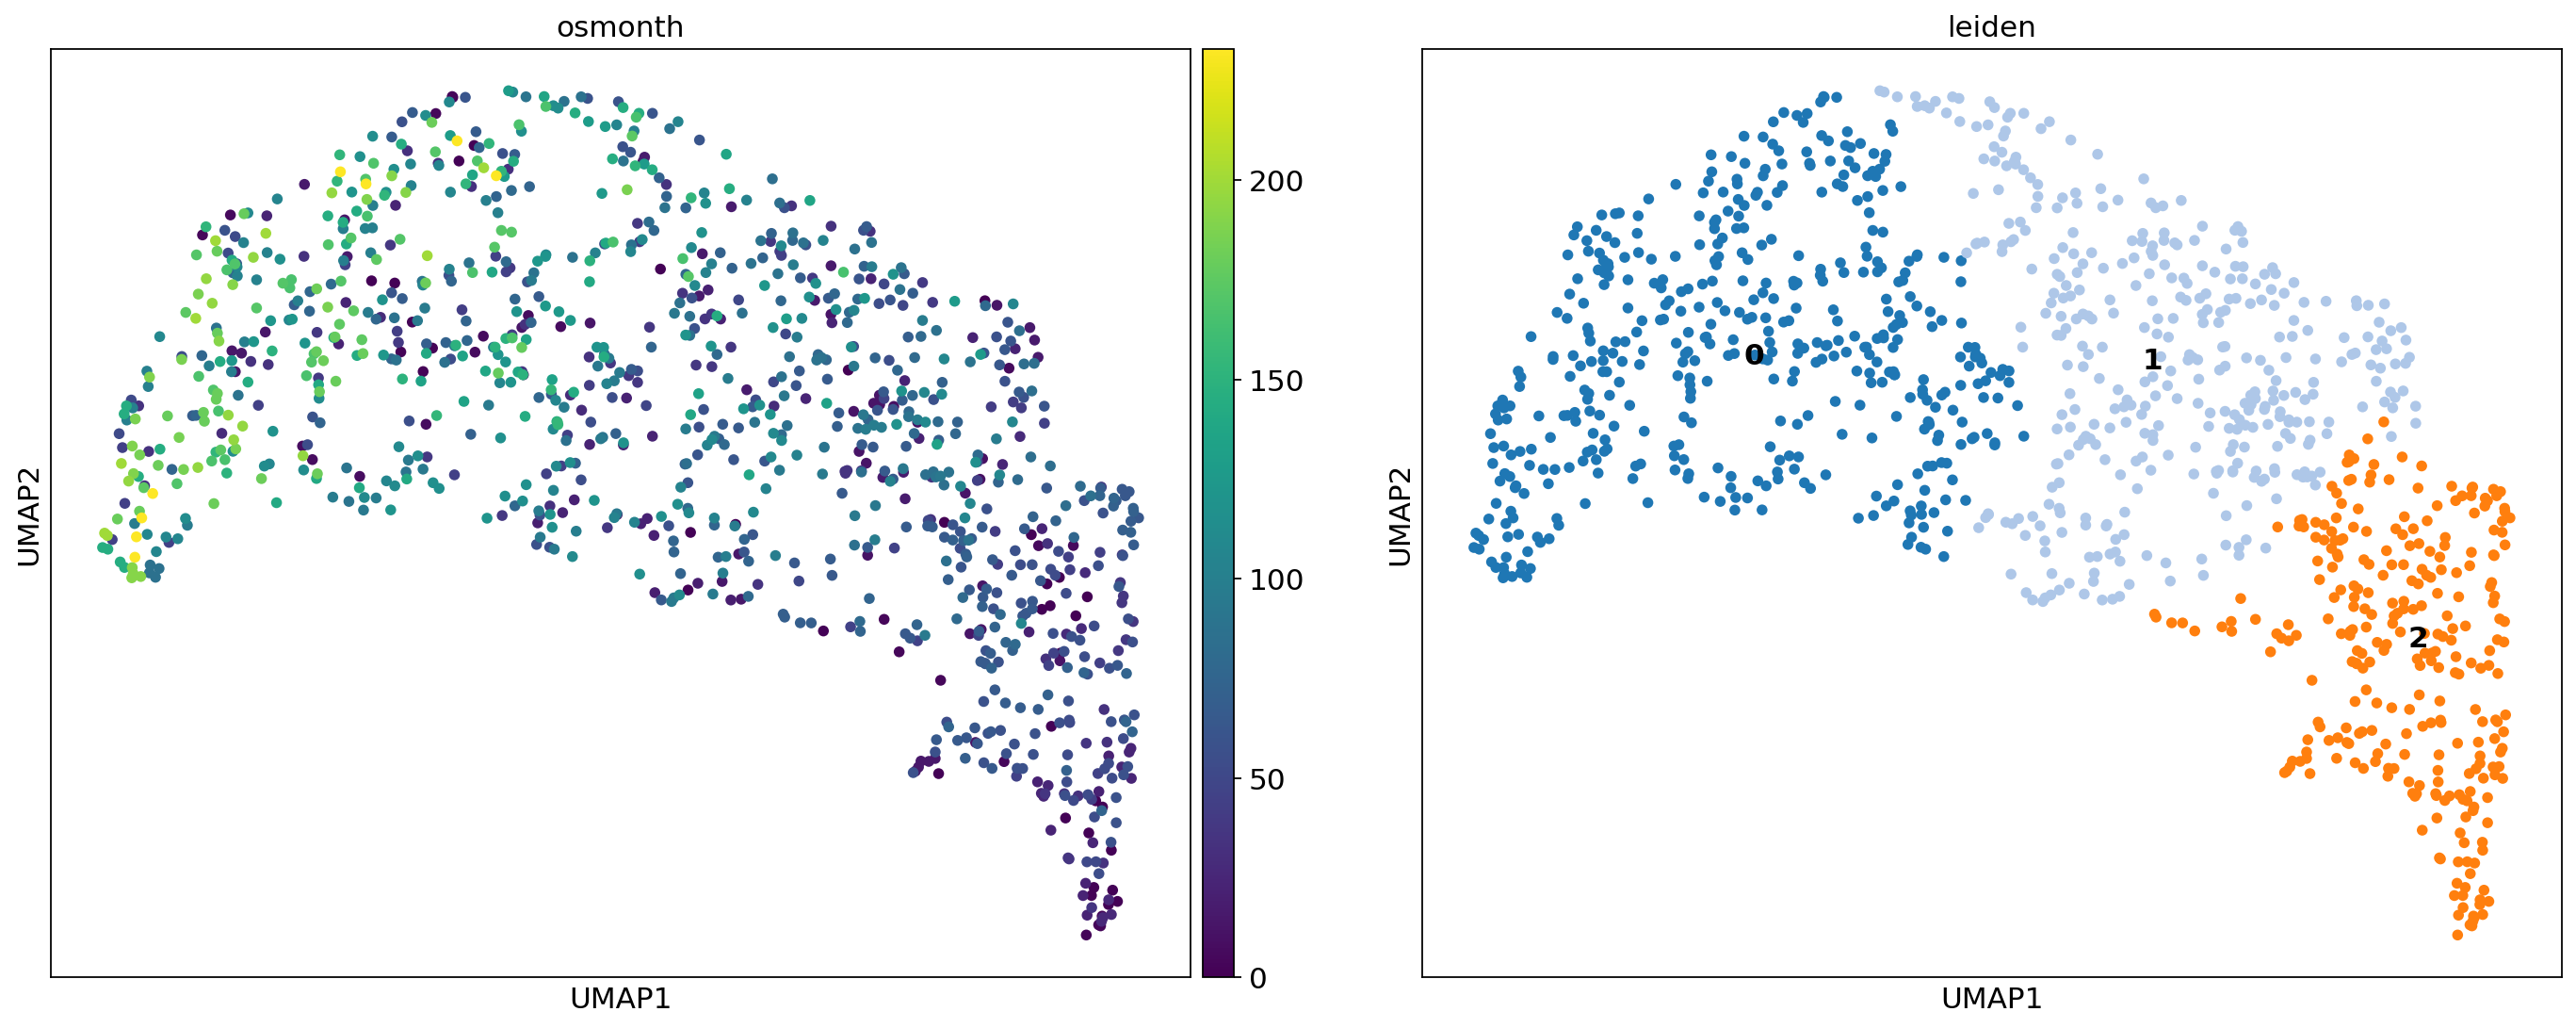

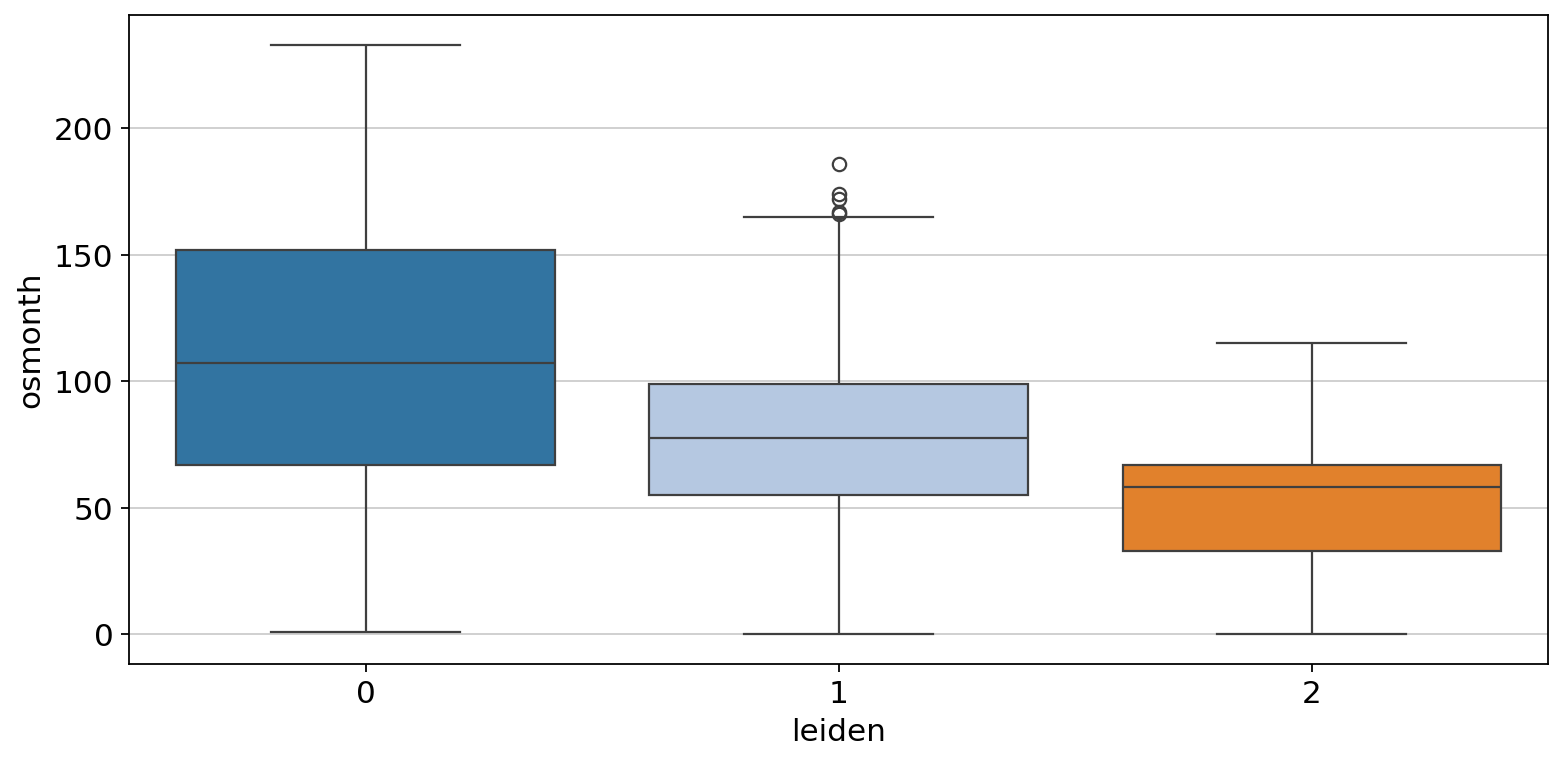

In [7]:
cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_emb.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_emb, color=["osmonth", "leiden"], palette=color_dict, show=False, legend_loc = 'on data') #, save="_jacksonfisher_embedding_boxplot.pdf")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_umap.pdf"), dpi=300)


fig = plt.figure(figsize=(10, 5))
sns.boxplot(data=adata_emb.obs, x="leiden", y="osmonth", palette= color_dict)
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_boxplot.pdf"), dpi=300)
# sc.pl.umap(adata, color=["leiden"], palette=color_dict, legend_loc = 'on data')
# sc.pl.umap(adata, color=["high_surv", "low_surv"], palette=["grey", "black"])
# sc.pl.umap(adata, color=["is_censored"], palette=["grey", "black"])

# sc.pl.dotplot(adata, n_genes=5, groupby='bulk_labels', dendrogram=True)

# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key=f"t-test", show=True, groupby=f"leiden")

<h2>Create Pseudobulk Profile (Important Nodes)</h2>

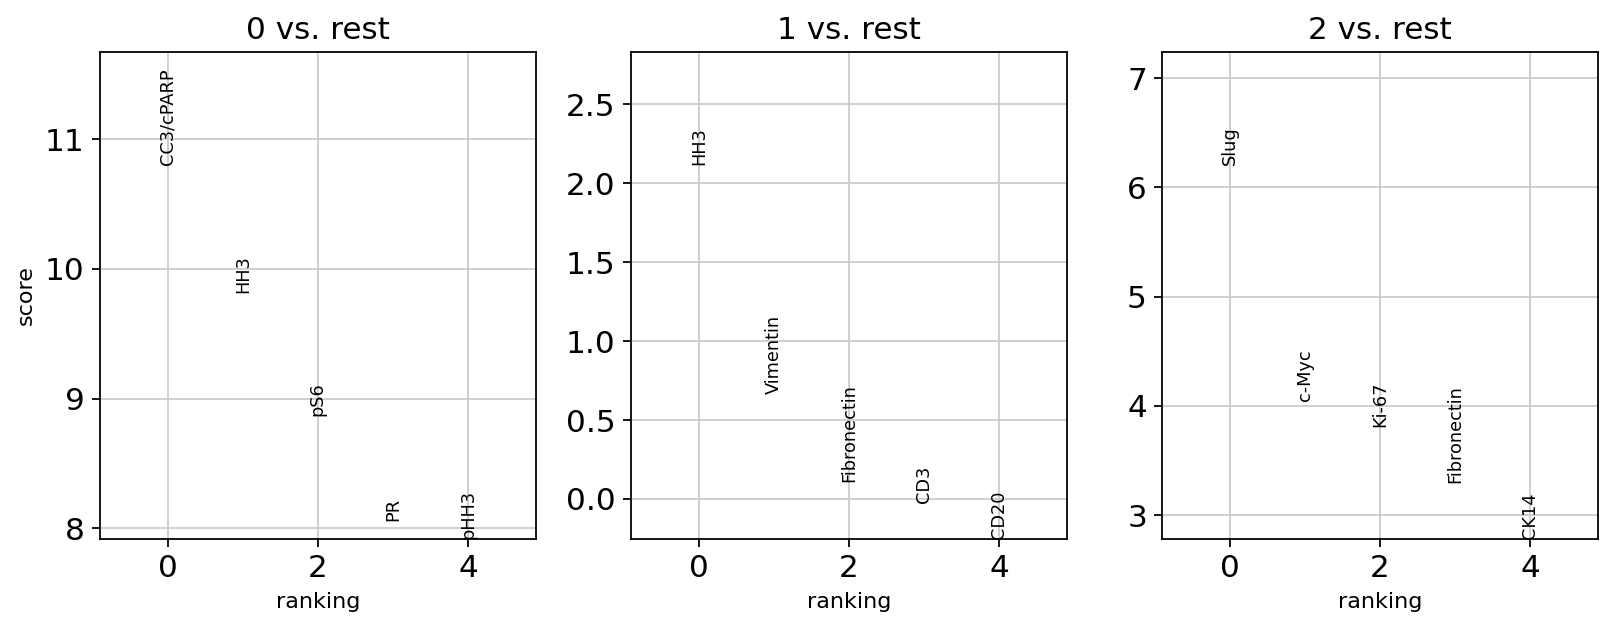

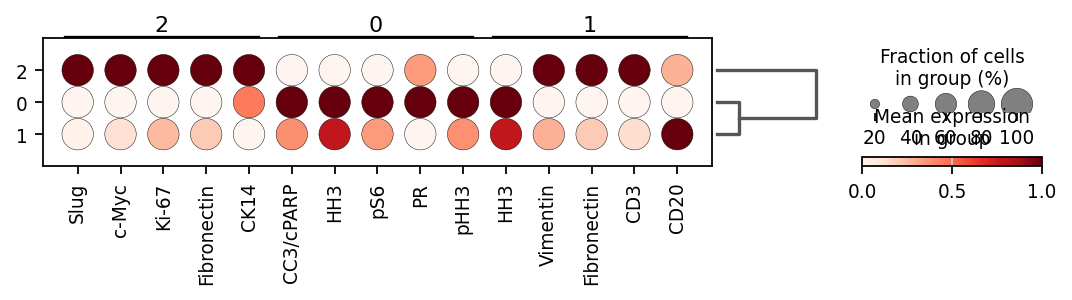

In [8]:
pdata_imp_vs_unimp = dc.get_pseudobulk(
    adata_exp,
    sample_col='img_id',
    groups_col='importance_hard',
    mode='mean',
    min_cells=0,
    min_counts=0
)

pdata_imp_vs_unimp.obs_names
pdata_imp = pdata_imp_vs_unimp[pdata_imp_vs_unimp.obs_names.str.contains("True"),:].copy()
new_obs_names = [obs_n.split("_")[0] for obs_n in pdata_imp.obs_names]
pdata_imp.obs_names = new_obs_names

pdata_imp.obs["leiden"] = adata_emb.obs["leiden"]
pdata_imp.obsm["X_umap"] = adata_emb.obsm["X_umap"]

sc.tl.rank_genes_groups(pdata_imp, groupby=f"leiden", method='wilcoxon', key_added = f"wilcoxon")

rcParams['figure.figsize']=(4,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
# plt.rcParams.update({'axes.xtick.labelsize' : 'large'})
# plt.rcParams.update({'axes.ytick.labelsize' : 'large'})  
sc.pl.rank_genes_groups(pdata_imp, n_genes=5, sharey=False,  key=f"wilcoxon", show=False, groupby="leiden")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_ranking.pdf"), dpi=300)
# plt.rcParams['figure.figsize']=(40,20)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon", figsize = (8,8), show=False, groupby="leiden")
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_dotplot.pdf"), dpi=300)

In [9]:
# TODO: Add leiden clusters to adta exp

for cat in adata_emb.obs["leiden"].cat.categories:
    img_ids = adata_emb[adata_emb.obs["leiden"]==cat].obs["img_id"].cat.categories
    adata_exp.obs.loc[adata_exp.obs["img_id"].isin(img_ids), "leiden"] = cat

print(sorted(adata_emb[adata_emb.obs["leiden"]=="0"].obs["img_id"].cat.categories))
print(sorted(adata_exp[adata_exp.obs["leiden"]=="0"].obs["img_id"].cat.categories))

adata_exp[adata_exp.obs["img_id"]=="108lr"]

['100ll', '100ur', '104ll', '108ll', '108lr', '108ul', '108ur', '109ll', '109lr', '109ur', '111lr', '111ul', '111ur', '112ll', '112lr', '115ll', '115lr', '115ul', '115ur', '116ll', '116lr', '116ul', '116ur', '117ul', '118ll', '118lr', '118ul', '118ur', '121ll', '121lr', '122ur', '124ll', '124ul', '124ur', '125ul', '126ur', '127ur', '128ll', '128lr', '128ul', '128ur', '12ll', '12lr', '12ul', '12ur', '13', '132ll', '132lr', '132ul', '132ur', '136lr', '136ur', '139ll', '139ul', '141ll', '141lr', '141ul', '141ur', '144ll', '144lr', '144ul', '144ur', '145ll', '145lr', '145ul', '145ur', '147', '149ll', '149lr', '14ll', '14lr', '14ul', '14ur', '150ll', '150lr', '150ul', '150ur', '151', '152', '153', '154', '155', '159ll', '15ll', '15lr', '15ul', '15ur', '165ll', '165ul', '167ll', '167lr', '167ul', '167ur', '169ll', '169lr', '169ul', '169ur', '16ll', '16lr', '16ul', '16ur', '170', '171ll', '171lr', '171ul', '171ur', '172', '173ll', '173lr', '173ul', '173ur', '175', '176lr', '177', '178ul', '17

View of AnnData object with n_obs × n_vars = 631 × 33
    obs: 'clinical_type', 'img_id', 'p_id', 'tumor_grade', 'osmonth', 'importance', 'importance_hard', 'cell_type', 'class', 'leiden'
    obsm: 'pos'

In [10]:
adata_exp

AnnData object with n_obs × n_vars = 843444 × 33
    obs: 'clinical_type', 'img_id', 'p_id', 'tumor_grade', 'osmonth', 'importance', 'importance_hard', 'cell_type', 'class', 'leiden'
    obsm: 'pos'

In [11]:
def plot_cell_type_proportion(adata, group_col="leiden", obs_col = "cell_type"):
    group_list = list(adata.obs[group_col].cat.categories)
    c_type_list = list(adata.obs[obs_col].cat.categories)
    # print(len(c_type_list))
    #c_type_list.remove("Large elongated")
    #c_type_list.remove("Macrohage")
    if obs_col=="cell_type":
        c_type_list.remove("Macrophage")
    print(len(c_type_list))
    c_type_list = c_type_list[:20]
    for cond in group_list:
        adata_tmp = adata[adata.obs[group_col]==cond,:]
        for c_type in c_type_list:
            if adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]<8:
                print(c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0])
                c_type_list.remove(c_type)
            # print(c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0])
            # cond_arr[-1].append(100*(adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]/adata_tmp.shape[0]))
    print(c_type_list)
    
    cond_prop = dict()
    cond_arr = []
    for cond in group_list:
        cond_arr.append([])
        # print(cond, cond_arr)
        cond_prop[cond] = []
        adata_tmp = adata[adata.obs[group_col]==cond,:]
        # print(adata_tmp.shape)
        sum = 0
        for c_type in c_type_list:
            # print("c_type", c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape)
            cond_arr[-1].append(100*(adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]/(adata_tmp[adata_tmp.obs[obs_col].isin(c_type_list),:].shape[0])))

    data = np.array(cond_arr).T
    # print("data", data.shape)
    # print(data)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # cmap = matplotlib.cm.get_cmap('tab20')
    # print(cmap.colors)

    X = np.arange(data.shape[1])
    
    for i in range(data.shape[0]):
        ax1.bar(X, data[i],bottom = np.sum(data[:i], 
                    axis =0), width= 0.85, color = cmap.colors[i], label=c_type_list[i]  )

    ax1.set_xticks([0,1,2])
    ax1.set_xticklabels(group_list) # , rotation=45)
    ax1.set_xlabel("Cluster", fontweight='bold')
    ax1.set_ylabel("Proportion (%)", fontweight='bold')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(bottom=0.45)
    plt.show()
    fig.tight_layout()
    # plt.savefig(f"../plots/sc_cell_type_annot/major_cell_type_prop_{cond_name}_barplot.pdf")



4
['Immune', 'Stroma', 'Tumor', 'Vessel']


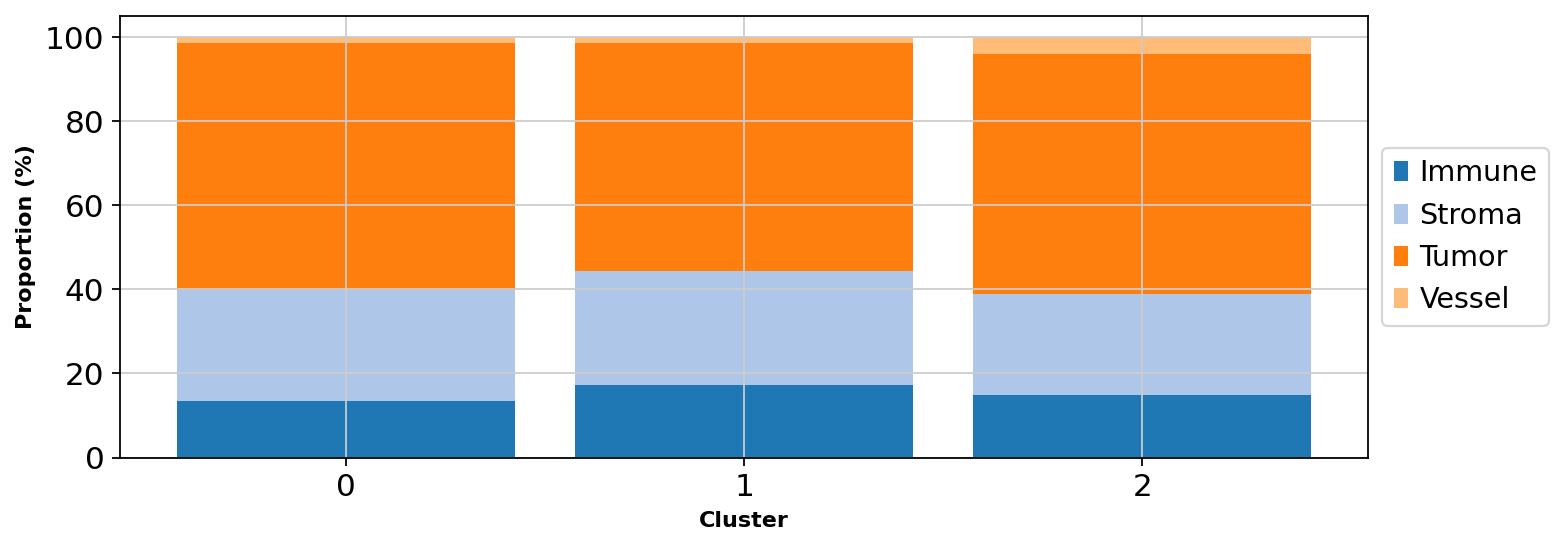

25
Large elongated 0
Macrohage 2
['Apoptotic', 'B cell', 'Basal CK', 'CK7+', 'CK7+ CK hi Ecadh hi', 'CK lo HR hi p53+', 'CK lo HR lo', 'CK+ HR hi', 'CK+ HR lo', 'CK+ HR+', 'Endothelial', 'Epithelial low', 'Fibronectin hi', 'Hypoxic', 'Myoepithelial', 'Proliferative', 'SMA hi Vimentin hi', 'Small circular']


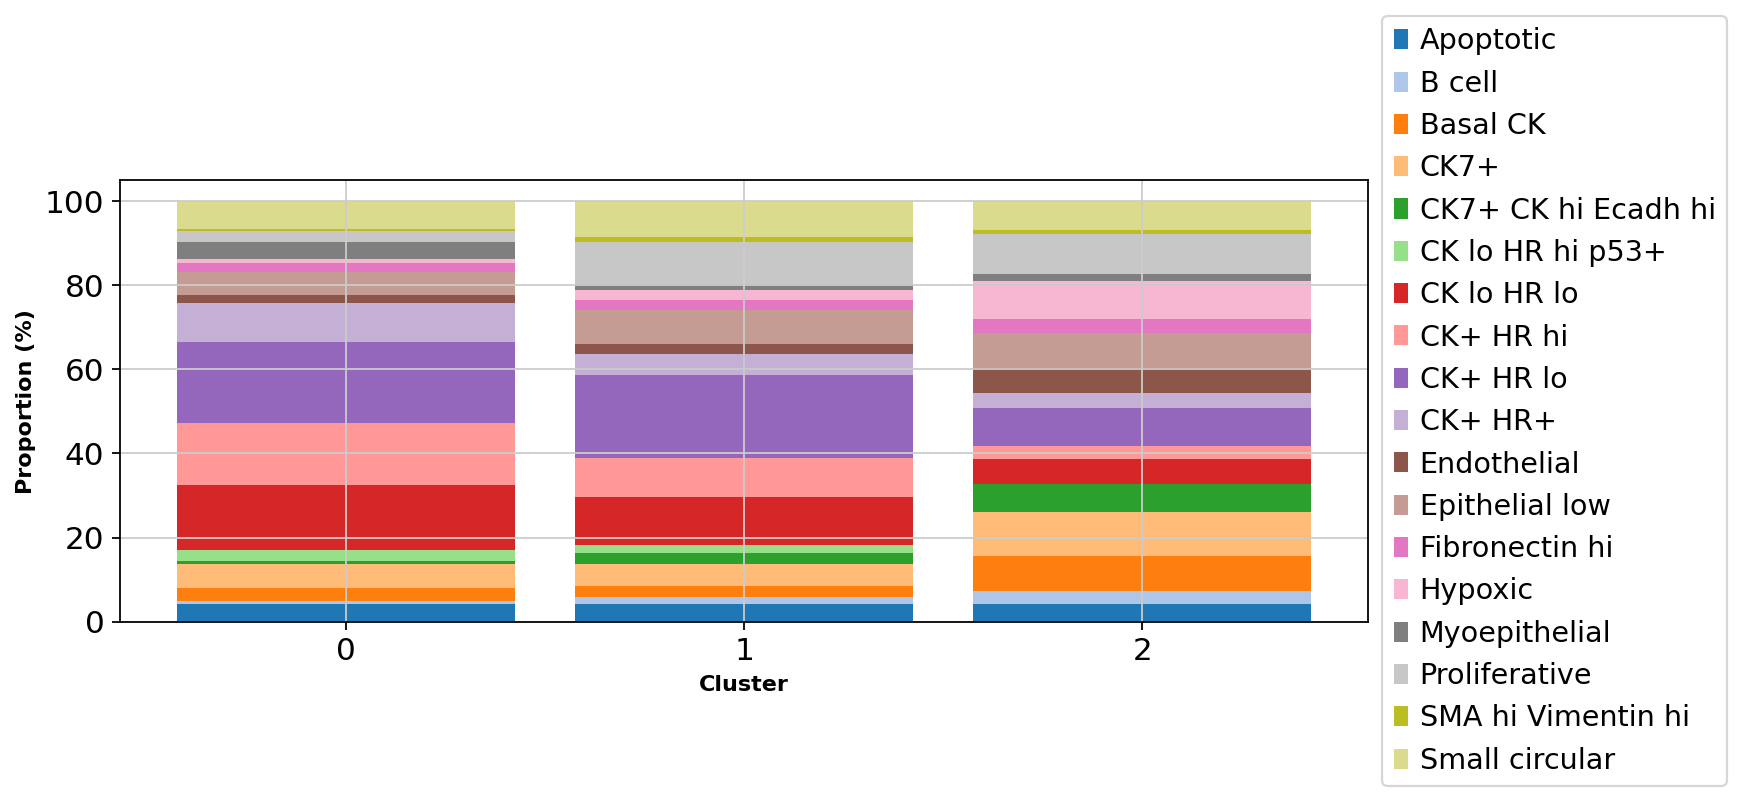

In [12]:
adata_exp.obs["leiden"] = adata_exp.obs["leiden"].astype("category")
# adata_exp[adata_exp.obs["importance_hard"]=="True",:]
# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "class")
# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "class")

plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "class")
plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "cell_type")
# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "cell_type")

In [13]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value

df_obs_pdataimp = pdata_imp.obs
df_obs_pdataimp
fvalue, pvalue = stats.f_oneway(df_obs_pdataimp[df_obs_pdataimp["leiden"]=="0"]["osmonth"], df_obs_pdataimp[df_obs_pdataimp["leiden"]=="2"]["osmonth"])
# df_obs_pdataimp[df_obs_pdataimp["leiden"]=="1"]["osmonth"], 
print(fvalue, pvalue)

269.2523212149527 8.08041172753446e-52


In [14]:

"""import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value

df_obs_pdataimp = pdata_imp.obs
fvalue, pvalue = stats.f_oneway(df_obs_pdataimp[df_obs_pdataimp["leiden"]=="0"], df_obs_pdataimp[df_obs_pdataimp["leiden"]=="2"])
print(fvalue, pvalue)
# 17.492810457516338 2.639241146210922e-05

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)
                sum_sq    df         F    PR(>F)
C(treatments)  3010.95   3.0  17.49281  0.000026
Residual        918.00  16.0       NaN       NaN

# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary
# output (ANOVA F and p value)
                 df   sum_sq   mean_sq         F    PR(>F)
C(treatments)   3.0  3010.95  1003.650  17.49281  0.000026
Residual       16.0   918.00    57.375       NaN       NaN

# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results."""

'import scipy.stats as stats\n# stats f_oneway functions takes the groups as input and returns ANOVA F and p value\n\ndf_obs_pdataimp = pdata_imp.obs\nfvalue, pvalue = stats.f_oneway(df_obs_pdataimp[df_obs_pdataimp["leiden"]=="0"], df_obs_pdataimp[df_obs_pdataimp["leiden"]=="2"])\nprint(fvalue, pvalue)\n# 17.492810457516338 2.639241146210922e-05\n\n# get ANOVA table as R like output\nimport statsmodels.api as sm\nfrom statsmodels.formula.api import ols\n\n# Ordinary Least Squares (OLS) model\nmodel = ols(\'value ~ C(treatments)\', data=df_melt).fit()\nanova_table = sm.stats.anova_lm(model, typ=2)\nanova_table\n# output (ANOVA F and p value)\n                sum_sq    df         F    PR(>F)\nC(treatments)  3010.95   3.0  17.49281  0.000026\nResidual        918.00  16.0       NaN       NaN\n\n# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)\nfrom bioinfokit.analys import stat\nres = stat()\nres.anova_stat(df=df_melt, res_var=\'value\', anova_model=\'va

In [15]:
"""
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))
adata_lower = adata_emb[adata_emb.obs["osmonth"]<lower_quartile,:].copy()

sc.tl.pca(adata_lower, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_lower)
sc.tl.umap(adata_lower)

sc.tl.leiden(adata_lower, resolution=0.1, key_added = "leiden_low_surv")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_lower.obs["leiden_low_surv"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_lower, show=False, color=["osmonth", "tumor_grade", "clinical_type"])
plt.savefig(os.path.join(PLT_PATH, "jacksonfisher_lowsurv_embedding_umap.pdf"), dpi=300)
sc.pl.umap(adata_lower, show=False, color="leiden_low_surv", palette=color_dict, legend_loc = 'on data')
plt.savefig(os.path.join(PLT_PATH, "jacksonfisher_lowsurv_embedding_clust_umap.pdf"), dpi=300)
plt.clf()
sns.boxplot(data=adata_lower.obs, x="leiden_low_surv", y="osmonth", showfliers = False, palette= color_dict)
plt.savefig(os.path.join(PLT_PATH, "jacksonfisher_lowsurv_embedding_boxplot.pdf"), dpi=300)
# sc.pl.violin(adata_lower, 'osmonth', groupby='leiden', palette=color_dict)

pdata_imp_low = pdata_imp[pdata_imp.obs_names.isin(adata_lower.obs_names),:].copy()

pdata_imp_low.obs["leiden_low_surv"] = adata_lower.obs["leiden_low_surv"]
pdata_imp_low.obsm["X_umap"] = adata_lower.obsm["X_umap"]

sc.tl.rank_genes_groups(pdata_imp_low, groupby=f"leiden_low_surv", method='wilcoxon', key_added = f"wilcoxon_low")
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_imp_low, n_genes=5, standard_scale='var', key=f"wilcoxon_low", show=False, groupby="leiden_low_surv")
plt.savefig(os.path.join(PLT_PATH, "jacksonfisher_psedu_imp_lowsurv_dotplot.pdf"), dpi=300)
"""

'\nlower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))\nadata_lower = adata_emb[adata_emb.obs["osmonth"]<lower_quartile,:].copy()\n\nsc.tl.pca(adata_lower, svd_solver=\'arpack\', random_state=0)\nsc.pp.neighbors(adata_lower)\nsc.tl.umap(adata_lower)\n\nsc.tl.leiden(adata_lower, resolution=0.1, key_added = "leiden_low_surv")\n\ncolor_dict = dict()\nmap = sns.palettes.get_colormap("tab20")\ncolor_dict = dict()\n\nfor ind, clust_index in enumerate(adata_lower.obs["leiden_low_surv"].cat.categories):\n    color_dict[clust_index] = cmap.colors[ind]\n\nrcParams[\'figure.figsize\']=(10,8)\nsc.pl.umap(adata_lower, show=False, color=["osmonth", "tumor_grade", "clinical_type"])\nplt.savefig(os.path.join(PLT_PATH, "jacksonfisher_lowsurv_embedding_umap.pdf"), dpi=300)\nsc.pl.umap(adata_lower, show=False, color="leiden_low_surv", palette=color_dict, legend_loc = \'on data\')\nplt.savefig(os.path.join(PLT_PATH, "jacksonfisher_lowsurv_embedding_clust_umap.pdf"), dpi=300)\nplt.clf()\nsns.

<h1>Clinical Subtype Analysis - Low vs. High Survivors</h1>

In [16]:
clinical_type = "HR+HER2-"
adata_emb_clinical_subtype = adata_emb[adata_emb.obs["clinical_type"]==clinical_type,:].copy()
upper_quartile = int(np.quantile(adata_emb_clinical_subtype.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb_clinical_subtype.obs["osmonth"], 0.25))

adata_emb_clinical_subtype.obs["high_surv"]="0"
adata_emb_clinical_subtype.obs["low_surv"]="0"

adata_emb_clinical_subtype.obs.loc[adata_emb_clinical_subtype.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb_clinical_subtype.obs.loc[adata_emb_clinical_subtype.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"

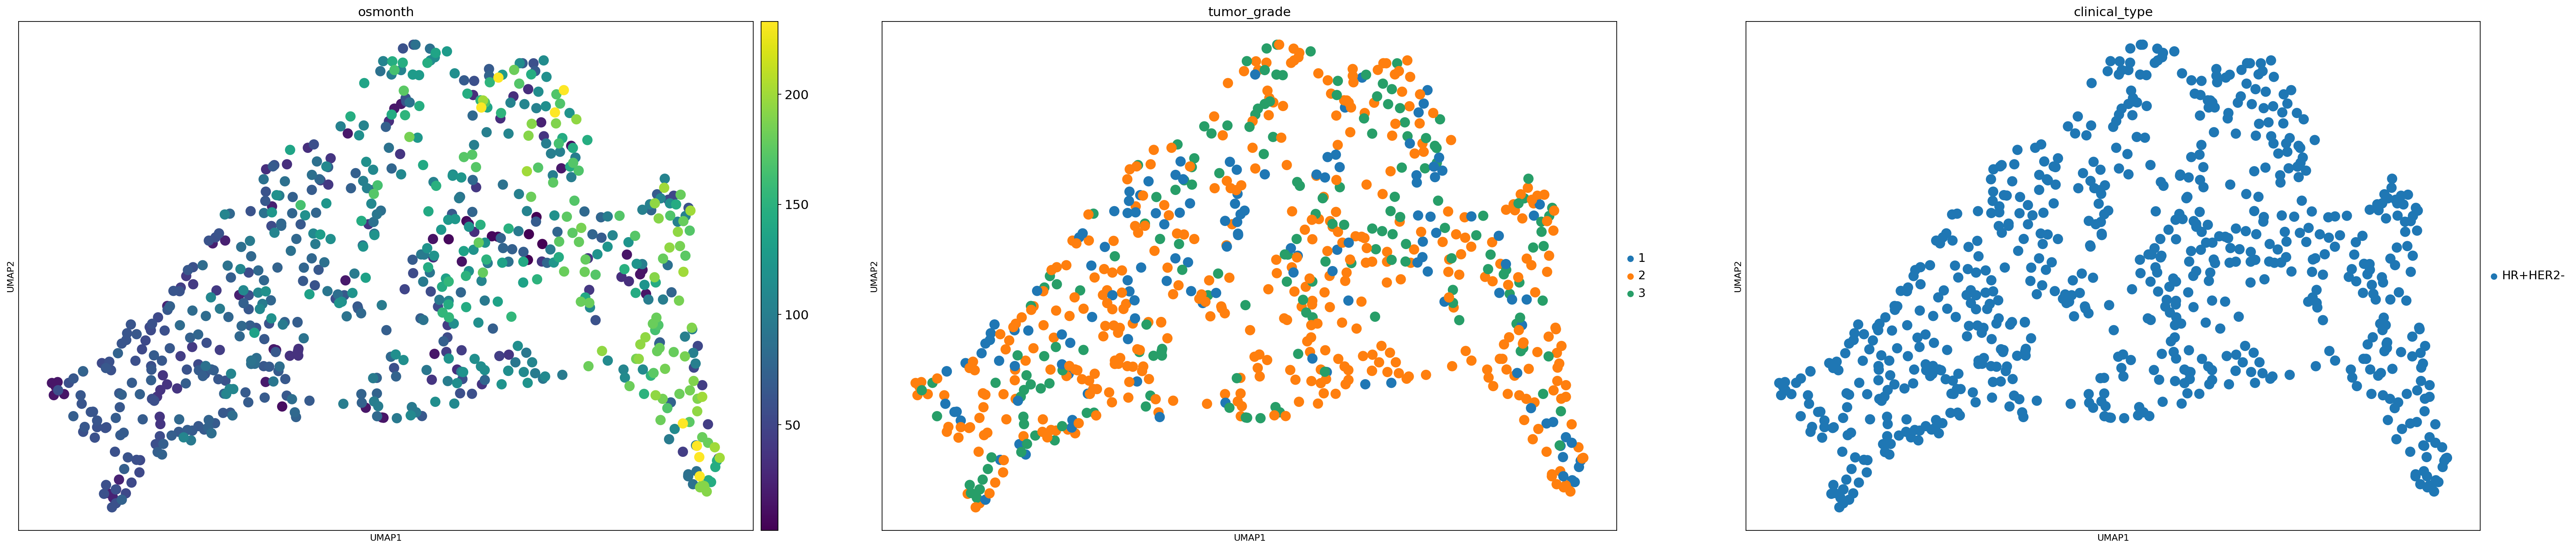

<Figure size 1200x800 with 0 Axes>

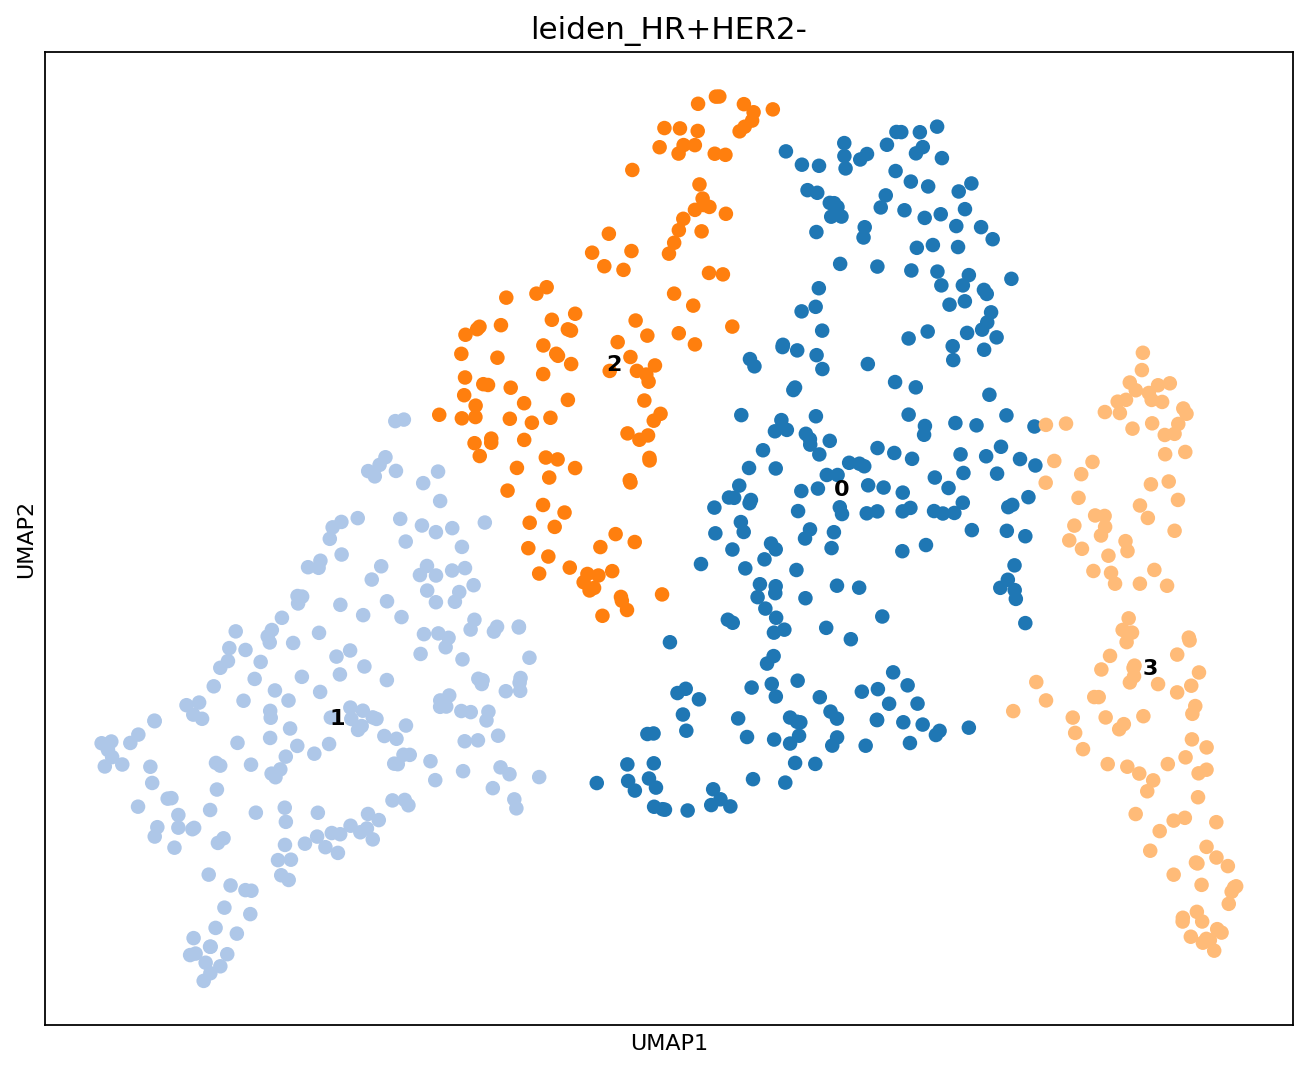

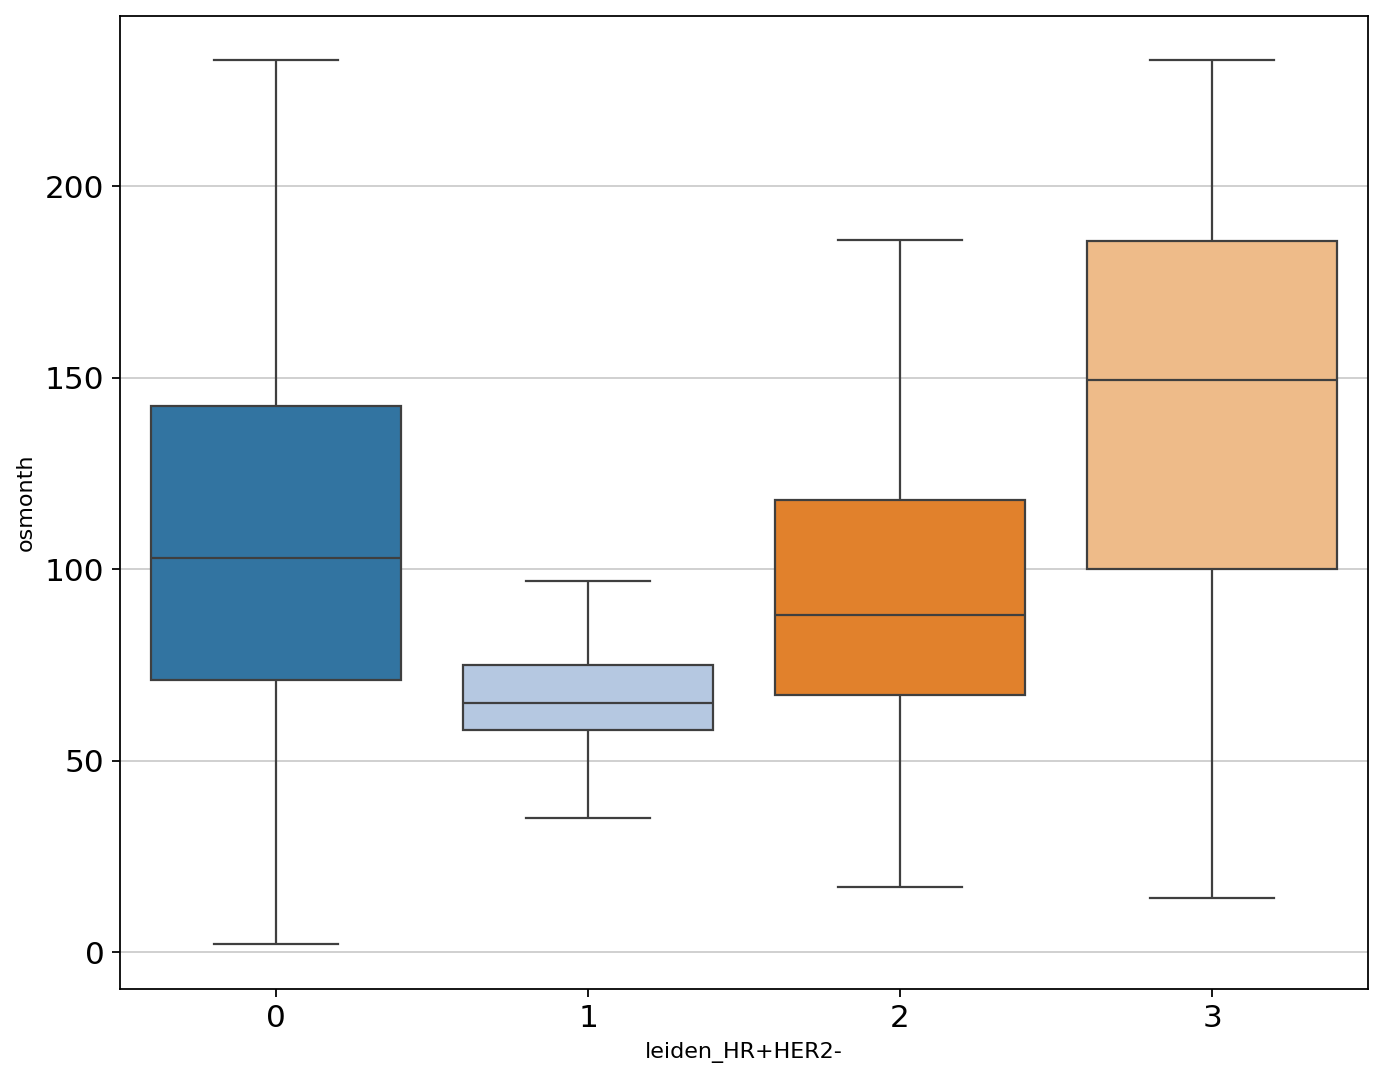

In [35]:
sc.tl.pca(adata_emb_clinical_subtype, svd_solver='arpack', random_state=42)
sc.pp.neighbors(adata_emb_clinical_subtype)
sc.tl.umap(adata_emb_clinical_subtype)

sc.tl.leiden(adata_emb_clinical_subtype, resolution=0.1, key_added = f"leiden_{clinical_type}")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]
rcParams['figure.figsize']=(15,10)
sc.pl.umap(adata_emb_clinical_subtype, size=500, color=["osmonth", "tumor_grade", "clinical_type"])
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_umap.pdf"), dpi=300)
plt.clf()
rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_emb_clinical_subtype, color=f"leiden_{clinical_type}", palette=color_dict, legend_loc = 'on data')
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_clust_umap.pdf"), dpi=300)
plt.clf()
sns.boxplot(data=adata_emb_clinical_subtype.obs, x=f"leiden_{clinical_type}", y="osmonth", showfliers = False, palette= color_dict)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_boxplot.pdf"), dpi=300)

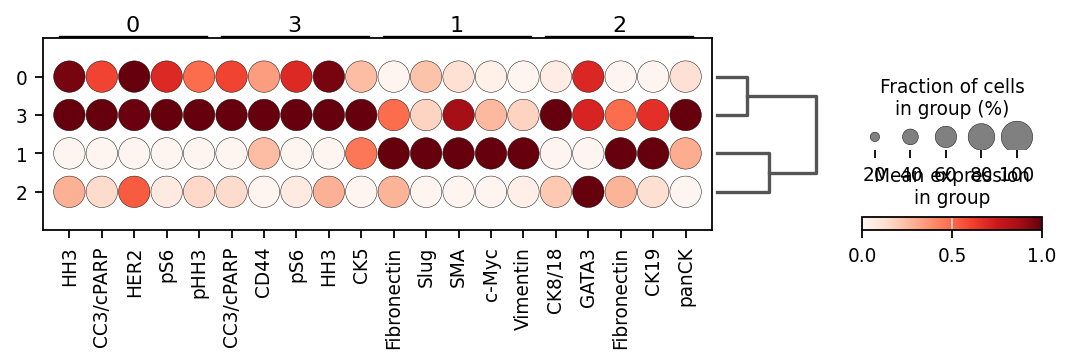

In [18]:
pdata_clinical_subtype = pdata_imp[pdata_imp.obs_names.isin(adata_emb_clinical_subtype.obs_names),:].copy()

pdata_clinical_subtype.obs[f"leiden_{clinical_type}"] = adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"]
pdata_clinical_subtype.obsm["X_umap"] = adata_emb_clinical_subtype.obsm["X_umap"]

sc.tl.rank_genes_groups(pdata_clinical_subtype, groupby=f"leiden_{clinical_type}", method='wilcoxon', key_added = f"wilcoxon_{clinical_type}")
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_clinical_subtype, n_genes=5, standard_scale='var', key=f"wilcoxon_{clinical_type}",  figsize = (8,12),  show=False, groupby=f"leiden_{clinical_type}")
plt.tight_layout()
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_{clinical_type}_dotplot.pdf"), dpi=300)


In [19]:
import scipy.stats as stats


In [20]:
# sc.tl.rank_genes_groups(pdata, 'importance_hard', method='t-test')
# sc.pl.rank_genes_groups(pdata, n_genes=10, sharey=False)

In [21]:
"""print(adata_exp.X.shape)
print(adata_exp.X[~np.isnan(adata_exp.X).any(axis=1)].shape)

print(pdata.X.shape)
print(pdata.X[~np.isnan(pdata.X).any(axis=1)].shape)"""

'print(adata_exp.X.shape)\nprint(adata_exp.X[~np.isnan(adata_exp.X).any(axis=1)].shape)\n\nprint(pdata.X.shape)\nprint(pdata.X[~np.isnan(pdata.X).any(axis=1)].shape)'

In [22]:
# imp_pdata.obs["leiden"] = adata_emb.obs["leiden"]
# imp_pdata.obsm["X_umap"] = adata_emb.obsm["X_umap"]

In [23]:

"""import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])
print(fvalue, pvalue)
# 17.492810457516338 2.639241146210922e-05

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)
                sum_sq    df         F    PR(>F)
C(treatments)  3010.95   3.0  17.49281  0.000026
Residual        918.00  16.0       NaN       NaN

# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary
# output (ANOVA F and p value)
                 df   sum_sq   mean_sq         F    PR(>F)
C(treatments)   3.0  3010.95  1003.650  17.49281  0.000026
Residual       16.0   918.00    57.375       NaN       NaN

# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results."""

"import scipy.stats as stats\n# stats f_oneway functions takes the groups as input and returns ANOVA F and p value\nfvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])\nprint(fvalue, pvalue)\n# 17.492810457516338 2.639241146210922e-05\n\n# get ANOVA table as R like output\nimport statsmodels.api as sm\nfrom statsmodels.formula.api import ols\n\n# Ordinary Least Squares (OLS) model\nmodel = ols('value ~ C(treatments)', data=df_melt).fit()\nanova_table = sm.stats.anova_lm(model, typ=2)\nanova_table\n# output (ANOVA F and p value)\n                sum_sq    df         F    PR(>F)\nC(treatments)  3010.95   3.0  17.49281  0.000026\nResidual        918.00  16.0       NaN       NaN\n\n# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)\nfrom bioinfokit.analys import stat\nres = stat()\nres.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')\nres.anova_summary\n# output (ANOVA F and p value)\n                 df   sum_sq

In [24]:
"""adata_uncensored = adata[adata.obs["is_censored"]==0,:].copy()

sc.tl.pca(adata_uncensored, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_uncensored)
sc.tl.umap(adata_uncensored)
sc.tl.leiden(adata_uncensored, key_added = "leiden")

# sc.pl.umap(adata, color=["osmonth", "leiden"])
upper_quartile = int(np.quantile(adata_uncensored.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_uncensored.obs["osmonth"], 0.25))


adata_uncensored.obs["high_surv"]="0"
adata_uncensored.obs["low_surv"]="0"

adata_uncensored.obs.loc[adata_uncensored.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_uncensored.obs.loc[adata_uncensored.obs["osmonth"]<lower_quartile, "low_surv" ] = "1" 


cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_uncensored.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata_uncensored, color=["osmonth"], palette=color_dict, legend_loc = 'on data')
sc.pl.umap(adata_uncensored, color=["leiden"], palette=color_dict, legend_loc = 'on data')
sc.pl.umap(adata_uncensored, color=["high_surv", "low_surv"], palette=["grey", "black"])
sns.boxplot(data=adata_uncensored.obs, x="leiden", y="osmonth", palette= color_dict)"""

'adata_uncensored = adata[adata.obs["is_censored"]==0,:].copy()\n\nsc.tl.pca(adata_uncensored, svd_solver=\'arpack\', random_state=0)\nsc.pp.neighbors(adata_uncensored)\nsc.tl.umap(adata_uncensored)\nsc.tl.leiden(adata_uncensored, key_added = "leiden")\n\n#\xa0sc.pl.umap(adata, color=["osmonth", "leiden"])\nupper_quartile = int(np.quantile(adata_uncensored.obs["osmonth"], 0.75))\nlower_quartile = int(np.quantile(adata_uncensored.obs["osmonth"], 0.25))\n\n\nadata_uncensored.obs["high_surv"]="0"\nadata_uncensored.obs["low_surv"]="0"\n\nadata_uncensored.obs.loc[adata_uncensored.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"\nadata_uncensored.obs.loc[adata_uncensored.obs["osmonth"]<lower_quartile, "low_surv" ] = "1" \n\n\ncmap = sns.palettes.get_colormap("tab20")\ncolor_dict = dict()\n\nfor ind, clust_index in enumerate(adata_uncensored.obs["leiden"].cat.categories):\n    color_dict[clust_index] = cmap.colors[ind]\n\nsc.pl.umap(adata_uncensored, color=["osmonth"], palette=color_dict, l